# SECOP II - Resultados variables e IRIC

En este notebook se realiza el análisis descriptivo y exploratorio para los datos de SECOP II - Master, y se crean las gráficas a usar en el artículo. Así mismo, se desarrolla 

## Entorno

In [1]:
import sys
print(sys.executable)
print(sys.getdefaultencoding())

c:\Users\andres.salazar\anaconda3\envs\vigia_art\python.exe
utf-8


In [2]:
#Librerias
import os
import pandas as pd
import numpy as np
import re
import datetime
import time

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

pd.plotting.register_matplotlib_converters()
pd.set_option('display.max_columns', None, 'display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#pd.options.display.max_colwidth = 100

In [4]:
os.getcwd()

'd:\\vigia\\articulo\\vigia_datos'

## Descripción variables iniciales

Se usan para poder crear estadísticas descriptivas y figuras que dependan del tiempo.

In [5]:
secopII_t = pd.read_csv('created_data\SECOPII_Master_t.csv')

In [6]:
secopII_t.shape

(87387, 61)

In [7]:
secopII_t['Modalidad de Contratacion'].value_counts(normalize=True)

Contratación directa                                          0.606
Contratación régimen especial                                 0.308
Mínima cuantía                                                0.028
Contratación Directa (con ofertas)                            0.015
Selección Abreviada de Menor Cuantía                          0.011
Selección abreviada subasta inversa                           0.011
Concurso de méritos abierto                                   0.007
Licitación pública                                            0.006
Contratación régimen especial (con ofertas)                   0.006
Licitación pública Obra Publica                               0.002
Seleccion Abreviada Menor Cuantia Sin Manifestacion Interes   0.000
Enajenación de bienes con subasta                             0.000
Name: Modalidad de Contratacion, dtype: float64

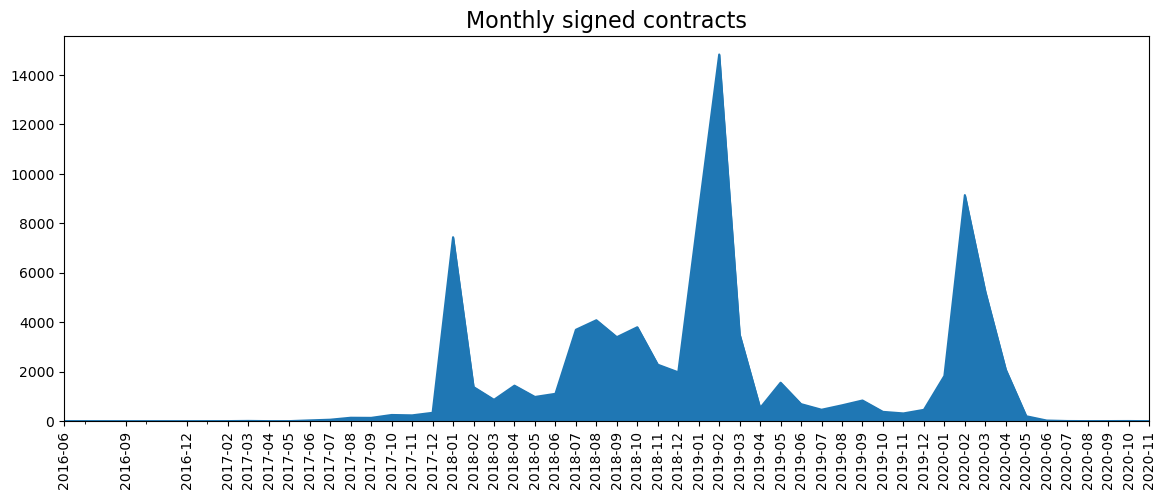

In [8]:
#Dar formato de fecha
secopII_t['Fecha de Firma'] = pd.to_datetime(secopII_t['Fecha de Firma'], format='%m/%d/%Y')
#Dar formato de periodicidad mensual
conteo_mensual_contratos = secopII_t['Fecha de Firma'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(14,5))
conteo_mensual_contratos.plot(kind='area')
plt.xticks(conteo_mensual_contratos.index, conteo_mensual_contratos.index, rotation=90)
plt.title('Monthly signed contracts', fontsize=16)
plt.show()

#Guardar
#plt.savefig('created_data/serie_contratos_firmados_mensual.png', bbox_inches = "tight")

In [9]:
(secopII_t['Fecha de Firma'] > '2020-01-01').value_counts()

False    68860
True     18527
Name: Fecha de Firma, dtype: int64

In [10]:
%%capture
modalities_data = secopII_t[['Modalidad de Contratacion', 'Fecha de Firma']].copy()

other_modalities = secopII_t['Modalidad de Contratacion'].value_counts().index[3:]
other_pos = secopII_t['Modalidad de Contratacion'].isin(other_modalities)

modalities_data.loc[other_pos, 'Modalidad de Contratacion'] = 'Otras'
modalities_data['mes_firma'] = secopII_t['Fecha de Firma'].dt.to_period('M')

modalities_plot_data = modalities_data.groupby(by=['Modalidad de Contratacion', 'mes_firma']).count().reset_index()
modalities_plot_data.rename(columns={'Fecha de Firma':'conteo'}, inplace=True)

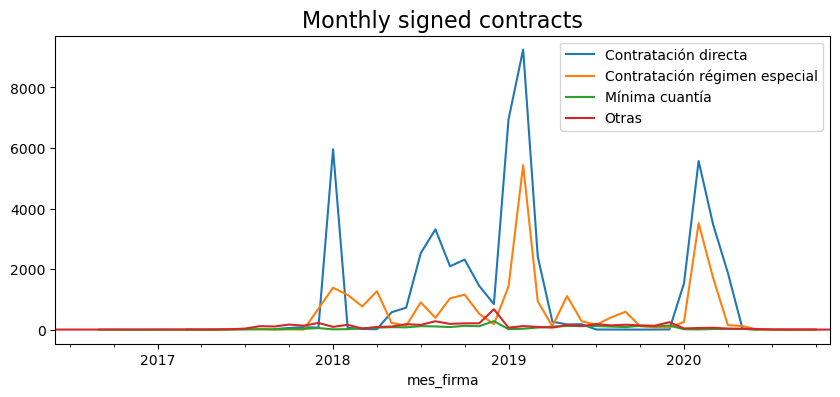

In [11]:
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in modalities_plot_data.groupby(['Modalidad de Contratacion']):
    grp.plot(x='mes_firma', y='conteo', ax=ax, label=key)
    #ax.plot(grp['mes_firma'], grp['conteo'], label=key)

ax.legend()
plt.title('Monthly signed contracts', fontsize=16)
#plt.xticks(conteo_mensual_contratos.index, conteo_mensual_contratos.index, rotation=90)
plt.show()

In [12]:
modalities_data['anio_firma'] = modalities_data['Fecha de Firma'].dt.to_period('Y')

In [13]:
conteo_anual_contratos = pd.pivot_table(modalities_data,
                                        'mes_firma', 'anio_firma', 'Modalidad de Contratacion', 'count')
conteo_anual_contratos

Modalidad de Contratacion,Contratación directa,Contratación régimen especial,Mínima cuantía,Otras
anio_firma,,,,
2016,NaN,NaN,1.000,3.000
2017,215.000,75.000,129.000,782.000
2018,19878.000,9092.000,1108.000,2360.000
2019,19225.000,10703.000,1109.000,1603.000
2020,12464.000,5740.000,86.000,241.000


In [14]:
conteo_anual_contratos.columns

Index(['Contratación directa', 'Contratación régimen especial',
       'Mínima cuantía', 'Otras'],
      dtype='object', name='Modalidad de Contratacion')

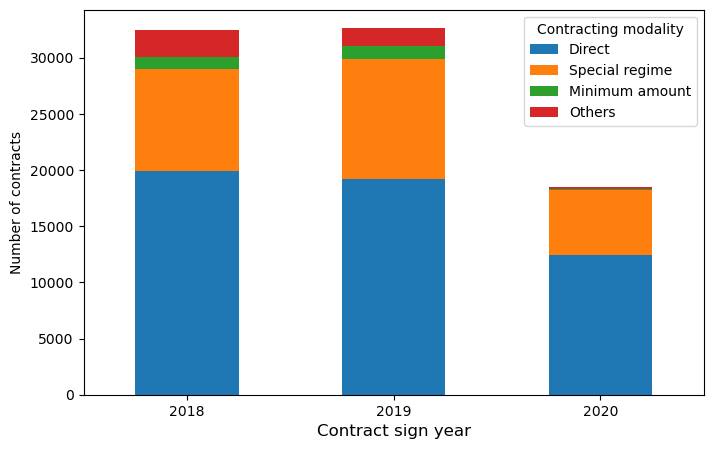

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
conteo_anual_contratos[conteo_anual_contratos.index > '2017'].plot.bar(stacked=True, ax=ax)
#ax.set_xticklabels(rotation=0)
ax.set_xlabel('Contract sign year', fontsize=12)
ax.set_ylabel('Number of contracts')
ax.legend(['Direct', 'Special regime', 'Minimum amount', 'Others'],
          loc='upper right', title='Contracting modality')
plt.xticks(rotation=0)
#ax.set_title('Number of contracts by modality across the years', fontsize=16) # Caption in doc
plt.savefig('created_data/figures/bar_contracts_year_modality.svg')

## Exploración - variables modelación

Para obtener los datos de la presente sección desde los anteriores se eliminaron variables que no presentaban variabilidad, se crearon variables nuevas y se hizo limpieza de las mismas. Además, se excluyeron de la muestra las observaciones con valor del contrato mayor al cuantil 0.995 que no sean del tipo "Obra", y las observaciones con valores del Saldo CDP superiores al cuantil 0.999.

In [16]:
secopII_master = pd.read_csv("created_data/SECOPII_Master_2.csv")

secopII_master['Codigo Segmento Categoria Principal'] = secopII_master['Codigo Segmento Categoria Principal'].astype('O')
#secopII_master = secopII_master.dropna()

In [17]:
secopII_master.shape

(87027, 41)

In [18]:
adiciones = secopII_master['Tuvo_adiciones'].value_counts()
adiciones

0    57823
1    29204
Name: Tuvo_adiciones, dtype: int64

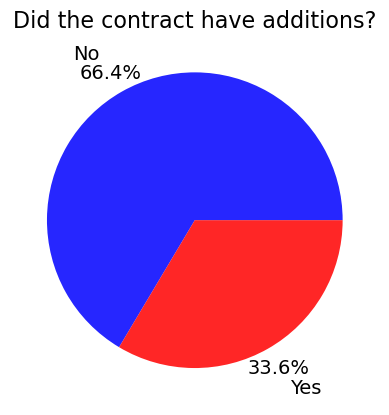

In [19]:
fig, ax = plt.subplots()
ax.pie(adiciones, labels=['No', 'Yes'], labeldistance=1.3, 
      pctdistance=1.15, autopct="%.1f%%", textprops={'fontsize': 14},
      colors=['b','r'], wedgeprops={'alpha':0.85})
plt.title('Did the contract have additions?', fontsize=16)
plt.savefig('created_data/figures/pie_additions.svg')

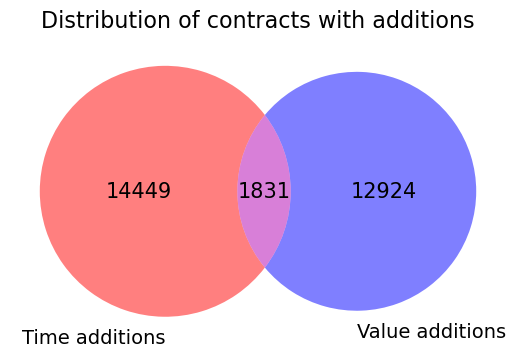

In [20]:
## Additions plots article
conteo_tipoadic = secopII_master.loc[secopII_master['Tuvo_adiciones']==1, 
                                     ['Tuvo_adiciones_valor', 'Tuvo_adiciones_tiempo']].value_counts().reset_index()
conteo_tipoadic.index = ['Time additions', 'Value additions', 'Additions']

#Gráfica ven
plt.figure()
v = venn2(subsets=conteo_tipoadic[0], set_labels=conteo_tipoadic.index,
          set_colors=('r', 'b'), alpha=0.5
         )
plt.title('Distribution of contracts with additions', fontsize=16)

for text in v.set_labels:
    text.set_fontsize(14)
for text in v.subset_labels:
    text.set_fontsize(15)
    
plt.savefig('created_data/figures/venndiag_additions.svg')

In [21]:
other_modalities = secopII_master['Modalidad de Contratacion'].value_counts().index[3:]
other_pos = secopII_master['Modalidad de Contratacion'].isin(other_modalities)

modalidad = secopII_master['Modalidad de Contratacion'].copy()
modalidad[other_pos] = 'Otras'
modalidad_c = modalidad.value_counts()

In [22]:
modalidad_c.index

Index(['Contratación directa', 'Contratación régimen especial', 'Otras',
       'Mínima cuantía'],
      dtype='object')

Text(0.5, 1.1, 'Contracting modality')

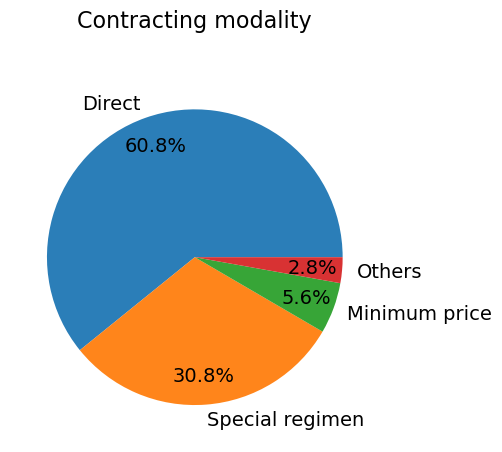

In [23]:
eng_labels = ['Direct', 'Special regimen', 'Minimum price', 'Others']
fig, ax = plt.subplots()
ax.pie(modalidad_c, labels=eng_labels, labeldistance=1.1, 
      pctdistance=0.8, autopct="%.1f%%", textprops={'fontsize': 14},
      wedgeprops={'alpha':0.95})
plt.title('Contracting modality', fontsize=16, y=1.1)

In [24]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [25]:
secopII_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87027 entries, 0 to 87026
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID Contrato                              87027 non-null  object 
 1   Nombre Entidad                           87027 non-null  object 
 2   Sector                                   87027 non-null  object 
 3   Entidad Centralizada                     87027 non-null  object 
 4   Tipo de Contrato                         87027 non-null  object 
 5   Modalidad de Contratacion                87027 non-null  object 
 6   Justificacion Modalidad de Contratacion  87027 non-null  object 
 7   TipoDocProveedor                         87027 non-null  object 
 8   Es Grupo                                 87027 non-null  object 
 9   Es Pyme                                  87027 non-null  object 
 10  Habilita Pago Adelantado                 87027

In [26]:
secopII_master['Sector'].value_counts(normalize=True)

Salud y Protección Social           0.411
Servicio Público                    0.178
Cultura                             0.140
Ambiente y Desarrollo Sostenible    0.056
Vivienda, Ciudad y Territorio       0.038
Transporte                          0.038
No aplica/No pertenece              0.023
Educación Nacional                  0.017
Hacienda y Crédito Público          0.017
defensa                             0.016
Inclusión Social y Reconciliación   0.014
Planeación                          0.013
Industria                           0.012
Trabajo                             0.011
Ley de Justicia                     0.011
interior                            0.004
Name: Sector, dtype: float64

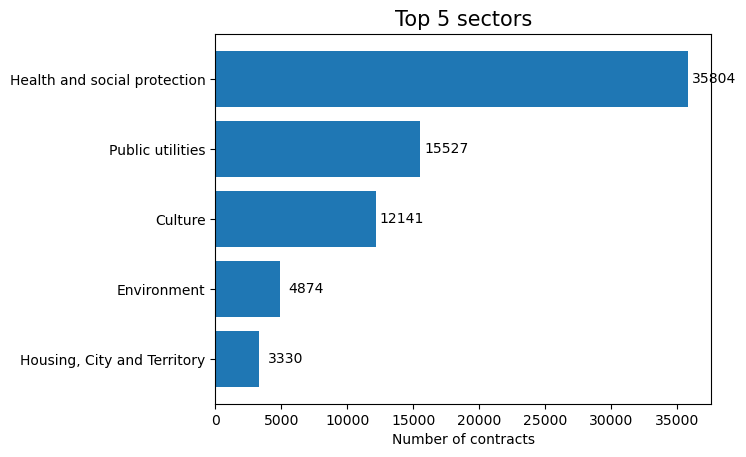

In [27]:
top5_sectores = secopII_master['Sector'].value_counts()[:5]
eng_labels = ['Health and social protection', 'Public utilities', 'Culture',
              'Environment', 'Housing, City and Territory']
plt.figure()
ax = plt.barh(eng_labels[::-1], top5_sectores[::-1])
for p in ax.patches:
    width = p.get_width()
    plt.text(p.get_width()+2000, p.get_y()+0.5*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')
plt.xlabel('Number of contracts')
plt.title( 'Top 5 sectors', fontsize=15)


plt.show()

In [28]:
secopII_master['Justificacion Modalidad de Contratacion'].value_counts()

ServiciosProfesionales                                                                        50247
Regla aplicable                                                                               24416
Presupuesto inferior al 10% de la menor cuantía                                                3401
Decreto 092 de 2017                                                                            2824
ContratosConveniosInteradministrativosValorCero                                                2049
Ley 1150 de 2007                                                                               1044
Suministro de bienes y servicios de características técnicas uniformes y común utilización      909
Ejecución de trabajos artísticos                                                                651
No existe pluralidad de oferentes en el mercado                                                 424
Arrendamiento de inmuebles                                                                      239


In [29]:
secopII_master['Grupo categoria principal'].value_counts()

Servicios administrativos               68011
Servicios(No Admin)                     16238
Productos manufacturados                 1980
Componentes y suministros de equipos      367
Materias primas                           237
Equipo industrial                         194
Name: Grupo categoria principal, dtype: int64

Gráficas por tipo de contrato.

El Decreto 092 de 2017 reglamenta la contratación con entidades privadas sin ánimo de lucro.

In [30]:
secopII_master['Tipo de Contrato'].value_counts()

Prestación de servicios       77058
Otro                           3191
Decreto 092 de 2017            2824
Compraventa                    1371
Suministros                    1114
Obra                            414
Interventoría                   404
Consultoría                     270
Arrendamiento de inmuebles      239
Seguros                         142
Name: Tipo de Contrato, dtype: int64

In [31]:
# 'Tipo de Contrato', 'Dias Fin-Inicio Contrato'
diff_otro_pos = secopII_master['Tipo de Contrato'] != 'Otro'
other_types = secopII_master['Tipo de Contrato'][diff_otro_pos].value_counts().index[4:]
other_types = list(other_types) + ['Otro']
other_pos = secopII_master['Tipo de Contrato'].isin(other_types)

tipos = secopII_master['Tipo de Contrato'].copy()
tipos[other_pos] = 'Otros'
tipos_c = tipos.value_counts()

Text(0.5, 1.0, 'Contracting type')

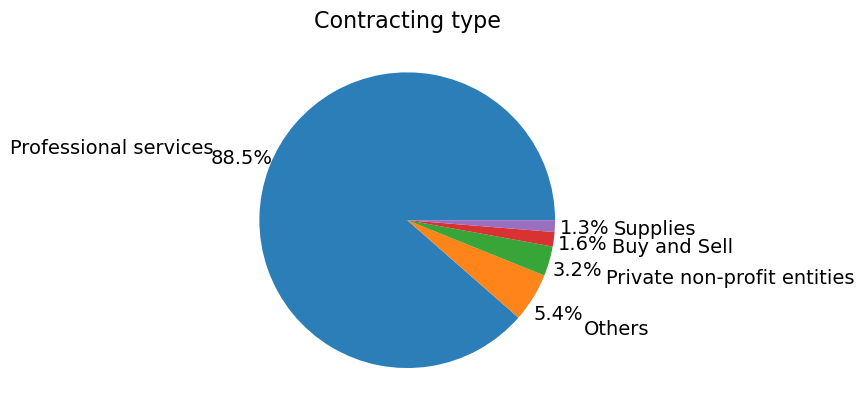

In [32]:
eng_labels = ['Professional services', 'Others', 'Private non-profit entities',
              'Buy and Sell', 'Supplies']
fig, ax = plt.subplots()
ax.pie(tipos_c, labels=eng_labels, labeldistance=1.4, 
      pctdistance=1.2, autopct="%.1f%%", textprops={'fontsize': 14},
      wedgeprops={'alpha':0.95})
plt.title('Contracting type', fontsize=16)


In [33]:
tipos_c

Prestación de servicios    77058
Otros                       4660
Decreto 092 de 2017         2824
Compraventa                 1371
Suministros                 1114
Name: Tipo de Contrato, dtype: int64

In [34]:
eng_labels = ['Professional services', 'Others', 'Private non-profit entities',
              'Buy and Sell', 'Supplies']
esp_labels = ['Prestación de servicios', 'Otros', 'Decreto 092 de 2017', 'Compraventa',
              'Suministros']
tipos = tipos.replace(dict(zip(esp_labels, eng_labels)))

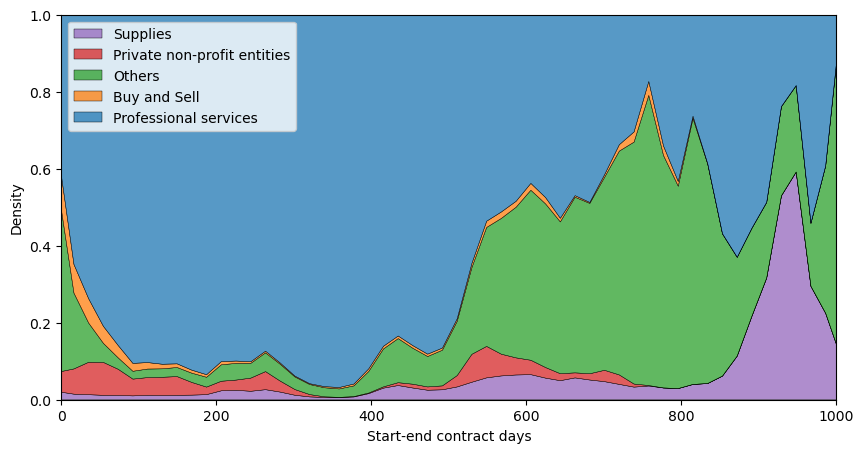

In [35]:
data_copy = secopII_master[['Dias Fin-Inicio Contrato', 'Tipo de Contrato']].copy()
data_copy['Contract type'] = tipos

plt.figure(figsize=(10,5))
sns.kdeplot(data=data_copy, x='Dias Fin-Inicio Contrato', hue='Contract type', multiple="fill",
           linewidth=0.3)
plt.xlim([0,1000])
plt.xlabel('Start-end contract days')
plt.legend(['Supplies', 'Private non-profit entities', 'Others',
              'Buy and Sell', 'Professional services'],loc='upper left')

plt.savefig('created_data/figures/kde_time_by_Ctype.svg')

## Explanatory variables relations

In [36]:
add_vars = ['Tuvo_adiciones_valor', 'Tuvo_adiciones_tiempo', 'Tuvo_adiciones']
corr_matrix = secopII_master.corr()[add_vars].drop(index=add_vars)
print(corr_matrix.index)

# Vars names to english
corr_matrix.columns = ['Additions in value', 'Additions in time', 'Additions']
eng_expv_names = ['Value', 'Budget balance', 'Number of invited providers',
                 'Number of direct invited providers', 'Number of answers',
                 'Number of processes', 'Number of SIC sanctions',
                 'Value of SIC sanctions', 'Sign-start contract days',
                 'Start-end contract days', 'Sign-start execution days',
                 'Start-end execution days', 'Days provider registered',
                 'Advance payment percentage', 'Balance/Value', 'portfolio',
                 'Days process open']
corr_matrix.index = eng_expv_names
corr_matrix.drop(index='portfolio', inplace=True)

Index(['Valor del Contrato', 'Saldo CDP', 'Proveedores Invitados',
       'Proveedores con Invitacion Directa', 'Conteo de Respuestas a Ofertas',
       'Numero_de_procesos_reportados', 'Numero multas SIC proveedor',
       'Valor acumulado multas SIC proveedor', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito',
       'Proporcion pagada adelantado', 'Saldo CDP respecto Valor',
       'Tiene_variables_portafolio', 'Dias Proceso Contratacion Abierto'],
      dtype='object')


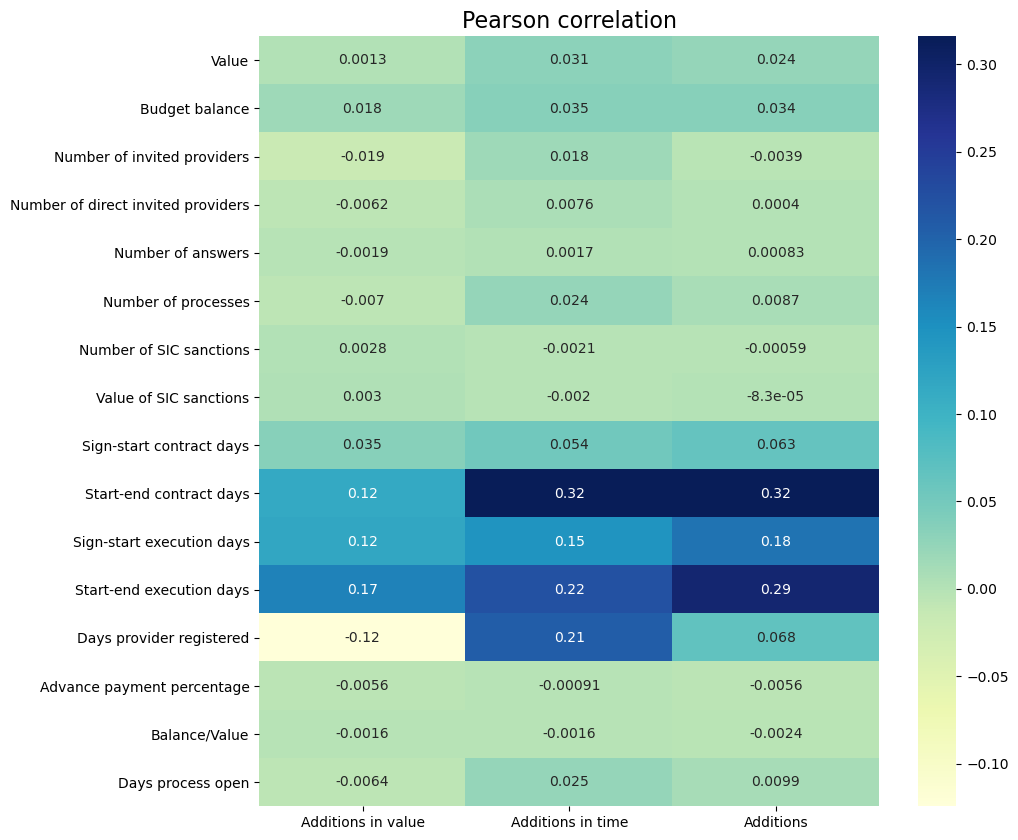

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, 
            annot=True, cmap='YlGnBu')
#plt.title('Pearson correlation between numerical explanatory variables and targets', fontsize=16)
plt.title('Pearson correlation', fontsize=16)
plt.savefig('created_data/figures/heatmap_pearsoncorr.svg')
plt.show()

del corr_matrix

In [38]:
import pycorrcat.pycorrcat as corrcat

expl_cat = ['Sector', 'Entidad Centralizada',
           'Tipo de Contrato', 'Modalidad de Contratacion',
           'Justificacion Modalidad de Contratacion', 'TipoDocProveedor',
           'Es Grupo', 'Es Pyme', 'Habilita Pago Adelantado', 'Liquidación',
           'Obligación Ambiental', 'EsPostConflicto', 'Destino Gasto',
           'Codigo Segmento Categoria Principal', 'Tipo Empresa Proveedor',
           'Mes Firma Contrato', 'Grupo categoria principal',
           'Tipo Empresa Proveedor Resumido', 'Mes de Publicacion del Proceso'
           ]
eng_expl_cat = ['Sector', 'Centralized entity', 'Contract type',
                'Contracting modality', 'Contracting modality justification',
                'Provider ID type', 'Is group', 'Is pyme', 'Allow pay in advance',
                'Sold out', 'Environmental obligation', 'Post-conflict',
                'Expenditure purpose', 'Product segment to contract',
                'Company type', 'Month of sign', 'Product group to contract',
                'Company type aggregation', 'Month of publication'
               ]

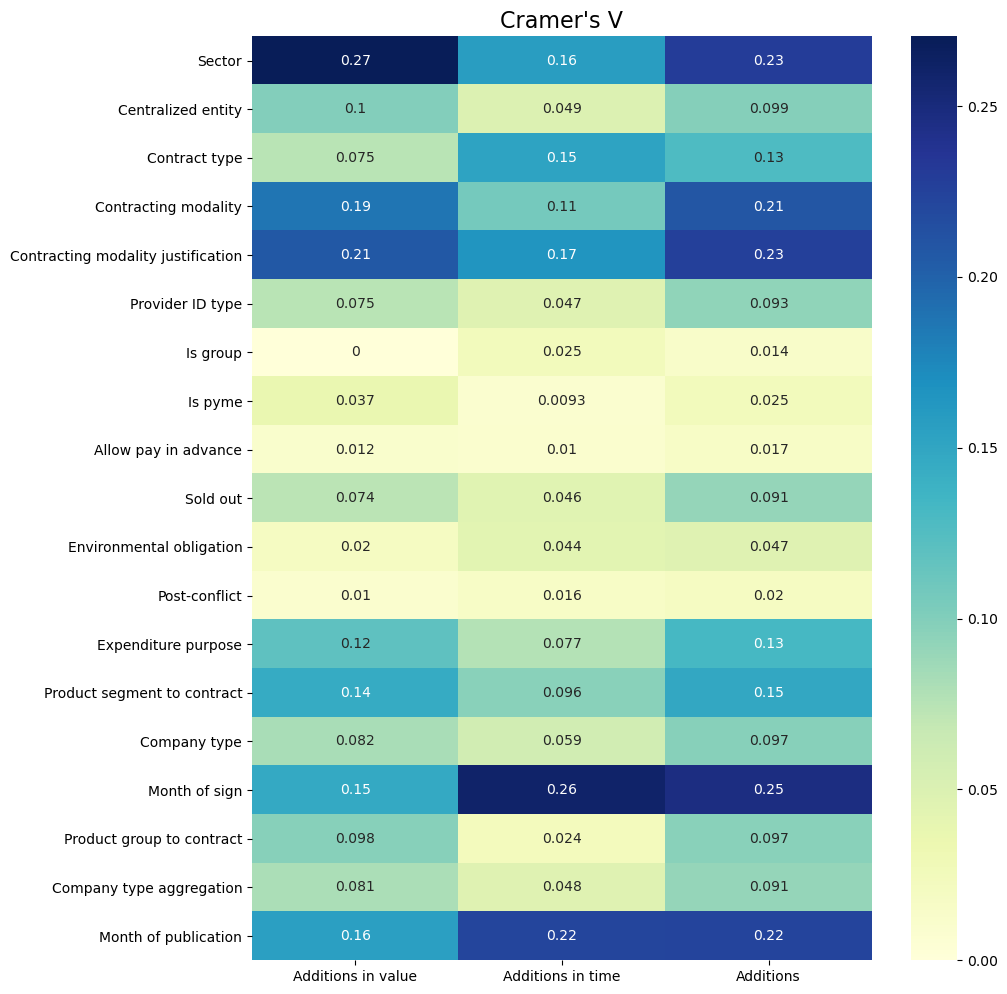

In [40]:
#Para variables categóricas usando la V de cramer
add_vars = ['Tuvo_adiciones_valor', 'Tuvo_adiciones_tiempo', 'Tuvo_adiciones']
catcorrM = corrcat.corr_matrix(secopII_master, 
                               columns=expl_cat+add_vars).drop(index=add_vars)
catcorrM = catcorrM[add_vars] 
# Vars names to english
catcorrM.columns = ['Additions in value', 'Additions in time', 'Additions']
catcorrM.index = eng_expl_cat

# Plot
plt.figure(figsize=(10,12))
sns.heatmap(catcorrM[['Additions in value', 'Additions in time', 'Additions']],
           annot=True, cmap='YlGnBu')
# plt.title('V de Cramer entre variables explicativas categóricas y objetivo', fontsize=16)
plt.title('Cramer\'s V', fontsize=16)
plt.savefig('created_data/figures/heatmap_cramersV.svg')
plt.show()

del catcorrM

## IRIC

Usando SECOPII Master t guardado

### Construir datos a nivel de proveedor

In [41]:
secopII_t = pd.read_csv('created_data\SECOPII_Master_t.csv')
secopII_t['Fecha de Firma'] = pd.to_datetime(secopII_t['Fecha de Firma'], format='%m/%d/%Y')

In [42]:
secopII_t.shape

(87387, 61)

In [43]:
secopII_t['Fecha de Firma'].describe(datetime_is_numeric=True)

count                            84814
mean     2019-02-10 21:37:25.978258432
min                2016-06-28 00:00:00
25%                2018-08-23 00:00:00
50%                2019-02-01 00:00:00
75%                2019-07-26 00:00:00
max                2020-11-13 00:00:00
Name: Fecha de Firma, dtype: object

Usar contratos firmados antes de 2020-07-01 para información de proveedor.

In [44]:
(secopII_t['Fecha de Firma'] > '2020-01-01').value_counts()

False    68860
True     18527
Name: Fecha de Firma, dtype: int64

In [45]:
secopII_t = secopII_t[secopII_t['Fecha de Firma'] < '2020-01-01']

In [46]:
secopII_t['Fecha de Firma'].describe(datetime_is_numeric=True)

count                            66283
mean     2018-10-26 22:00:59.417949952
min                2016-06-28 00:00:00
25%                2018-07-23 00:00:00
50%                2018-12-27 00:00:00
75%                2019-02-11 00:00:00
max                2019-12-31 00:00:00
Name: Fecha de Firma, dtype: object

In [47]:
vars_AP = ['Documento Proveedor', 'Tuvo_adiciones_valor', 'Tuvo_adiciones_tiempo']
vars_prov = ['proveedor_adiciones_valor', 'proveedor_adiciones_tiempo']

secopII_t[vars_prov] = secopII_t[vars_AP].groupby('Documento Proveedor').transform('sum').apply(lambda x: 1*(x!=0) )

# Base a nivel de proveedores
proveedores_adiciones = secopII_t[vars_AP].groupby('Documento Proveedor').sum().reset_index()

In [48]:
secopII_t.rename(columns={'Documento Proveedor':'documento_proveedor'}, inplace=True)
proveedores_adiciones.rename(columns={'Documento Proveedor':'documento_proveedor'}, inplace=True)

In [49]:
# Historial del ganador: nÃºmero de contratos adjudicados.
proveedores_historial = secopII_t['documento_proveedor'].value_counts().reset_index()
proveedores_historial = proveedores_historial.rename(columns={'index':'documento_proveedor',
                                                            'documento_proveedor': 'numero_procesos'})

# Empresa multiproposito: Segmentos principales que ha servido.
# Base a nivel de proveedores
vars_cp = ['documento_proveedor','Codigo Segmento Categoria Principal']
proveedores_segmentos = secopII_t[vars_cp].groupby('documento_proveedor')['Codigo Segmento Categoria Principal'].apply(set).reset_index()

# Diversidad de entidades: Entidades con las que ha ganado contratos.
vars_de = ['documento_proveedor','Nit Entidad']
proveedores_entidades = secopII_t.groupby('documento_proveedor')['Nit Entidad'].apply(set).reset_index()

In [50]:
proveedores = proveedores_adiciones.merge(proveedores_historial,
                                        on='documento_proveedor',
                                        how='outer',
                                        validate='1:1'
                                        )
proveedores = proveedores.merge(proveedores_segmentos,
                                on='documento_proveedor',
                                how='outer',
                                validate='1:1'
                            )
proveedores = proveedores.merge(proveedores_entidades,
                                on='documento_proveedor',
                                how='outer',
                                validate='1:1'
                            )
# Modificar nombres
proveedores.rename(columns={'Nit Entidad':'codigos_entidades',
                            'Codigo Segmento Categoria Principal': 'segmentos_de_categoria_principal',
                            'Tuvo_adiciones_valor': 'numero_adiciones_valor',
                            'Tuvo_adiciones_tiempo': 'numero_adiciones_tiempo'
                        },inplace=True)

# NÃºmero segmentos
proveedores['segmentos_de_categoria_principal'] = proveedores['segmentos_de_categoria_principal'].apply(len)

#NÃºmero entidades
proveedores['codigos_entidades'] = proveedores['codigos_entidades'].apply(len)

In [51]:
proveedores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40791 entries, 0 to 40790
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   documento_proveedor               40791 non-null  object
 1   numero_adiciones_valor            40791 non-null  int64 
 2   numero_adiciones_tiempo           40791 non-null  int64 
 3   numero_procesos                   40791 non-null  int64 
 4   segmentos_de_categoria_principal  40791 non-null  int64 
 5   codigos_entidades                 40791 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.2+ MB


### Calcular índice

In [52]:
secopII_t = pd.read_csv('created_data\SECOPII_Master_t.csv')
secop2_PR_api = pd.read_csv('created_data\secop2_proveedores_registrados.csv')

In [53]:
secopII_t['Fecha de Firma'] = pd.to_datetime(secopII_t['Fecha de Firma'], format='%m/%d/%Y')

Usar contratos firmados desde de 2020-07-01 para calcular indice a contratos con registro previo de proveedor.

In [54]:
secopII_t = secopII_t[(secopII_t['Fecha de Firma'] >= '2020-01-01')]

In [55]:
secopII_t['Fecha de Firma'].describe(datetime_is_numeric=True)

count                            18531
mean     2020-02-28 13:37:29.052938240
min                2020-01-01 00:00:00
25%                2020-02-07 00:00:00
50%                2020-02-21 00:00:00
75%                2020-03-17 00:00:00
max                2020-11-13 00:00:00
Name: Fecha de Firma, dtype: object

In [56]:
# Proveedores invitados
secop2_PR_api['fecha_creacion'] = pd.to_datetime(secop2_PR_api['fecha_creacion'])
secop2_PR_api = secop2_PR_api.groupby('nit').min().reset_index()

# Agregar a contratos electrónicos
secopII_t = secopII_t.merge(secop2_PR_api,
                                    left_on='Documento Proveedor', right_on='nit',
                                    how='left'
                                    )
secopII_t.drop(columns='nit', inplace=True)

In [57]:
p_dum = proveedores.copy()
del proveedores

In [58]:
old_names = ['ID Contrato', 'Tipo de Contrato', 'Sector', 'Valor del Contrato', 'Fecha de Firma',
    'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato', 'Fecha de Inicio de Ejecucion', 'Fecha de Fin de Ejecucion',
    'Codigo de Categoria Principal', 'Justificacion Modalidad de Contratacion', 'Proceso de Compra', 'Documento Proveedor',
    'Modalidad de Contratacion', 'TipoDocProveedor', 'Nombre Entidad', 'Proveedores Unicos con Respuestas',
    'fecha_creacion', 'Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación', 'Proveedores Invitados']

new_names = ['id_contrato', 'tipo_de_contrato', 'sector', 'valor_del_contrato', 'fecha_de_firma',
    'fecha_de_inicio_del_contrato', 'fecha_de_fin_del_contrato', 'fecha_de_inicio_de_ejecucion', 'fecha_de_fin_de_ejecucion',
    'codigo_de_categoria_principal', 'justificacion_modalidad_de', 'proceso_de_compra', 'documento_proveedor',
    'modalidad_de_contratacion', 'tipodocproveedor', 'nombre_entidad', 'proveedores_unicos_con',
    'fecha_creacion', 'fecha_de_publicacion_del', 'fecha_de_ultima_publicaci', 'proveedores_invitados']
rename_dict = dict(zip(old_names, new_names))

# New data
secop2_CE_api = secopII_t[old_names].copy()
secop2_CE_api.rename(columns=rename_dict, inplace=True)

In [59]:
## Formatos
# Fechas
var_fechas = ['fecha_de_firma', 'fecha_de_inicio_del_contrato',
            'fecha_de_fin_del_contrato', 'fecha_de_fin_de_ejecucion', 'fecha_de_inicio_de_ejecucion',
            'fecha_creacion', 'fecha_de_publicacion_del', 'fecha_de_ultima_publicaci', 
            ]
secop2_CE_api[var_fechas] = secop2_CE_api[var_fechas].apply(pd.to_datetime)

# Numéricas
secop2_CE_api['valor_del_contrato'] = secop2_CE_api['valor_del_contrato'].astype('int64')
secop2_CE_api['proveedores_invitados'] = secop2_CE_api['proveedores_invitados'].fillna(0).astype(int)

## Variables de días
secop2_CE_api['Dias Inicio-Firma Contrato'] = (secop2_CE_api['fecha_de_inicio_del_contrato'] - \
                                            secop2_CE_api['fecha_de_firma']).dt.days
secop2_CE_api['Dias Fin-Inicio Contrato'] = (secop2_CE_api['fecha_de_fin_del_contrato'] - \
                                            secop2_CE_api['fecha_de_inicio_del_contrato']).dt.days
secop2_CE_api['Dias Inicio-Firma Ejecucion'] = (secop2_CE_api['fecha_de_inicio_de_ejecucion'] - \
                                                secop2_CE_api['fecha_de_firma']).dt.days
secop2_CE_api['Dias Fin-Inicio Ejecucion'] = (secop2_CE_api['fecha_de_fin_de_ejecucion'] - \
                                            secop2_CE_api['fecha_de_inicio_de_ejecucion']).dt.days
secop2_CE_api['Dias Proveedor Inscrito'] = (secop2_CE_api['fecha_de_firma'] - \
                                            secop2_CE_api['fecha_creacion']).dt.days
secop2_CE_api['Dias Proceso Contratacion Abierto'] = (secop2_CE_api['fecha_de_ultima_publicaci'] - \
                                                    secop2_CE_api['fecha_de_publicacion_del']).dt.days
secop2_CE_api['Periodo de Decision'] = (secop2_CE_api['fecha_de_firma'] - \
                                        secop2_CE_api['fecha_de_ultima_publicaci']).dt.days

# Para días proveedor inscrito
# Se imputan como 0 los valores nulos y negativos para indicar que no estaba inscrito al momento de firmar el contrato.
secop2_CE_api['Dias Proveedor Inscrito'].fillna(0, inplace=True)
secop2_CE_api.loc[secop2_CE_api['Dias Proveedor Inscrito'] < 0, 'Dias Proveedor Inscrito'] = 0
secop2_CE_api['Dias Proveedor Inscrito'] = secop2_CE_api['Dias Proveedor Inscrito'].astype(int)
# Se requiere convertir a entero en este caso debido a que la presencia de missings el atributo days se vuelve flotante.

# Para días proceso de contratación abierto
# Dar valor de 0 a negativos, -1, y vacios con 0
secop2_CE_api.loc[secop2_CE_api['Dias Proceso Contratacion Abierto'] < 0, 'Dias Proceso Contratacion Abierto'] = 0
secop2_CE_api['Dias Proceso Contratacion Abierto'].fillna(0, inplace=True)
secop2_CE_api['Dias Proceso Contratacion Abierto'] = secop2_CE_api['Dias Proceso Contratacion Abierto'].astype(int)

# Para días del periodo de decisión
# Dar valor de 0 a negativos, -1. Y vacios con 0
secop2_CE_api.loc[secop2_CE_api['Periodo de Decision'] < 0, 'Periodo de Decision'] = 0
secop2_CE_api['Periodo de Decision'].fillna(0, inplace=True)
secop2_CE_api['Periodo de Decision'] = secop2_CE_api['Periodo de Decision'].astype(int)

# Mes Firma Contrato en febrero
secop2_CE_api['Mes Firma Contrato_Feb'] = 1 * (secop2_CE_api['fecha_de_firma'].dt.month == 2)

# Eliminar fechas usadas
var_fechas_drop = ['fecha_de_inicio_del_contrato', 'fecha_de_fin_del_contrato',
            'fecha_de_inicio_de_ejecucion', 'fecha_de_fin_de_ejecucion', 'fecha_creacion',
            'fecha_de_ultima_publicaci', 'fecha_de_publicacion_del'
            ]
secop2_CE_api.drop(columns=var_fechas_drop, inplace=True)

# Variables a binarias
secop2_CE_api['Sector_Cultura'] = 1 * (secop2_CE_api.sector.str.upper() == 'CULTURA')
secop2_CE_api['Sector_Salud y Proteccion Social'] = 1 * (secop2_CE_api.sector == 'Salud y Protección Social')

secop2_CE_api['Justificacion Modalidad de Contratacion_Decreto 092 de 2017'  # Sigue en la siguiente linea
    ] = 1 * (secop2_CE_api.justificacion_modalidad_de.str.upper() == 'DECREE092/2017')

# Crear grupo de categoría principal del objeto a contratar. (Innecesario acá)
# secop2_CE_api['codigo_de_categoria_principal'] = secop2_CE_api['codigo_de_categoria_principal'
#                                                               ].str.replace('V1.', '', regex=False).astype('int64')
# Código del segmento
Cseg = secop2_CE_api['codigo_de_categoria_principal'].floordiv(1000000)
secop2_CE_api['Grupo categoria principal_Servicios administrativos'] = 1 * (Cseg == 80)

# 'Codigo Segmento Categoria Principal_85000000' (Healthcare services)
secop2_CE_api['Segmento_categoria_principal_servicios_salud'] = 1 * (Cseg == 85)

del Cseg

# Esta se usará para marcar distinguir observaciones a usar para cada modelo.
secop2_CE_api['Tipo_contrato_prestacion_de_servicios'] = 1 * (
            secop2_CE_api.tipo_de_contrato == 'Prestación de servicios')

In [60]:
# Proveedor con adiciones en valor
p_dum['adicion_valor_proveedor'] = p_dum['numero_adiciones_valor'].apply(lambda x: 1 * (x != 0))
# Proveedor con adiciones en tiempo
p_dum['adicion_tiempo_proveedor'] = p_dum['numero_adiciones_tiempo'].apply(lambda x: 1 * (x != 0))
# Proveedor recurrente
p_dum['proveedor_recurrente'] = p_dum['numero_procesos'].apply(lambda x: 1 * (x >= 5))
# Proveedor multiproposito
p_dum['proveedor_multiproposito'] = p_dum['segmentos_de_categoria_principal'].apply(lambda x: 1 * (x > 1))
# Proveedor multientidad
p_dum['proveedor_multientidad'] = p_dum['codigos_entidades'].apply(lambda x: 1 * (x > 1))

# Eliminar variables originales
p_dum.drop(columns=['numero_adiciones_valor', 'numero_adiciones_tiempo', 'numero_procesos',
                    'segmentos_de_categoria_principal', 'codigos_entidades'],
        inplace=True
        )
# Agregar a contratos electrónicos
secop2_CE_api = secop2_CE_api.merge(p_dum, how='left',
                                    on='documento_proveedor',
                                    validate='m:1'
                                    )

## Contratación directa
secop2_CE_api['contratacion_directa'] = secop2_CE_api['modalidad_de_contratacion'].apply(
    (lambda x: 1 if ((x == 'Contratación directa') | (x == 'Contratación Directa (con ofertas)')) else 0))

## Contratación por régimen especial
secop2_CE_api['contratacion_regimen_especial'] = secop2_CE_api['modalidad_de_contratacion'].apply(
    (lambda x: 1 if (
                (x == 'Contratación régimen especial') | (x == 'Contratación régimen especial (con ofertas)')) else 0))

## Ausencia de proceso de contratación
# Se usa la variable _merge generada previamente al juntar los datos de procesos de contratación.
# secop2_CE_api['ausencia_proceso_contratacion'] = 1 * (secop2_CE_api['_merge'] == 'left_only')
# secop2_CE_api.drop(columns='_merge', inplace=True)
secop2_CE_api['ausencia_proceso_contratacion'] = 1*secop2_CE_api['proveedores_unicos_con'].isna() # Para este caso desde temporal

## Duración extrema del proceso de contratación
# Los umbrales de 5 y 90 son escogidos basados en Zuleta, Ospino y Caro 2019.
secop2_CE_api['duracion_extrema_proceso'] = secop2_CE_api['Dias Proceso Contratacion Abierto'].apply(
    lambda x: 1 if ((x >= 90) | (x <= 5)) else 0)

## Periodo de decisión extremo
secop2_CE_api['periodo_decision_extremo'] = secop2_CE_api['Periodo de Decision'].apply(
    lambda x: 1 if ((x > 60) | (x < 1)) else 0)

## Proponente único
secop2_CE_api['proponente_unico'] = 1 * (secop2_CE_api['proveedores_unicos_con'] <= 1)


## Errores o ausencia de datos.
# Esta se basa en 3 características clave: identificación del proveedor, registro del valor
#  y justificación de la modalidad de contratación.

# Errores en identificación del proveedor.
def error_doc(row):
    '''
    Esta función se usa para asignar contratos con errores
    en el reporte del documento del proveedor
    '''

    if (row['tipodocproveedor'] == 'No Definido'):
        return 1

    if (len(row['documento_proveedor']) < 6):
        return 1

    if re.match(r'^[\W|a-zA-Z]+$',
                row['documento_proveedor']):  # Documento conformado solo por caracteres especiales o letras.
        return 1
    else:
        return 0


error_documento = secop2_CE_api.apply(error_doc, axis=1)

# Ausencia de justificaciÃ³n de la modalidad.
secop2_CE_api['justificacion_modalidad_de'] = secop2_CE_api['justificacion_modalidad_de'].str.lower()
error_justificacion = secop2_CE_api['justificacion_modalidad_de'].apply(
    lambda x: 1 if ((pd.isna(x)) | (x == 'no especificado')) else 0)

# Errores en el reporte del valor del contrato.
# Los umbrales se toman de los percentiles 99 de la distribución del valor según el tipo de contrato.
error_valor = 1*( ( (secop2_CE_api['tipo_de_contrato']=='Obra') & 
                    ( secop2_CE_api['valor_del_contrato'] > 207282285507.51996) ) | 
                ( (secop2_CE_api['tipo_de_contrato']!='Obra') &
                    (secop2_CE_api['valor_del_contrato'] > 5445114808.67) ) |
                ( (secop2_CE_api['tipo_de_contrato']=='Prestación de servicios') &
                    (secop2_CE_api['valor_del_contrato'] > 221053429.5299997) )
                )
# Unificar errores o ausencias
secop2_CE_api['presencia_errores'] = 1 * (error_documento + error_justificacion + error_valor != 0)

# -------------------------------- #
# ------ Calculo del índice ------ #
vars_indice = ['proponente_unico', 'proveedor_multiproposito', 'proveedor_recurrente', 'proveedor_multientidad',
            'contratacion_directa', 'contratacion_regimen_especial', 'presencia_errores', 'duracion_extrema_proceso',
            'periodo_decision_extremo', 'adicion_valor_proveedor', 'adicion_tiempo_proveedor',
            'ausencia_proceso_contratacion'
            ]
# En caso de NaN al ser proveedor nuevo lo suma como 0.
secop2_CE_api['iric'] = secop2_CE_api[vars_indice].sum(axis=1) / len(vars_indice)


In [61]:
# ------ Calculo del índice ponderado------ #
transf_valor = np.log(secop2_CE_api['valor_del_contrato']+1)
ponderacion_valor = transf_valor/17.4875  #Correspondiente al percentil 75 de la distribución 
secop2_CE_api.loc[transf_valor!=0,'iricp'] = secop2_CE_api['iric']*ponderacion_valor
secop2_CE_api.loc[transf_valor==0,'iricp'] = secop2_CE_api['iric']  #En caso de valor 0 permanece igual.

In [62]:
transf_valor.describe(percentiles=[0.25, 0.5, 0.75])

count   18531.000
mean       16.411
std         2.567
min         0.000
25%        16.209
50%        16.720
75%        17.281
max        23.814
Name: valor_del_contrato, dtype: float64

In [63]:
secop2_CE_api['fecha_de_firma'].describe()

c:\Users\andres.salazar\anaconda3\envs\vigia_art\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   18531
unique                    165
top       2020-02-13 00:00:00
freq                      685
first     2020-01-01 00:00:00
last      2020-11-13 00:00:00
Name: fecha_de_firma, dtype: object

### Resultados para contratos firmados en 2020

In [64]:
secop2_CE_api.columns

Index(['id_contrato', 'tipo_de_contrato', 'sector', 'valor_del_contrato',
       'fecha_de_firma', 'codigo_de_categoria_principal',
       'justificacion_modalidad_de', 'proceso_de_compra',
       'documento_proveedor', 'modalidad_de_contratacion', 'tipodocproveedor',
       'nombre_entidad', 'proveedores_unicos_con', 'proveedores_invitados',
       'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato',
       'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion',
       'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto',
       'Periodo de Decision', 'Mes Firma Contrato_Feb', 'Sector_Cultura',
       'Sector_Salud y Proteccion Social',
       'Justificacion Modalidad de Contratacion_Decreto 092 de 2017',
       'Grupo categoria principal_Servicios administrativos',
       'Segmento_categoria_principal_servicios_salud',
       'Tipo_contrato_prestacion_de_servicios', 'adicion_valor_proveedor',
       'adicion_tiempo_proveedor', 'proveedor_recurrente',
       'provee

In [65]:
secop2_CE_api[['iric', 'iricp']].describe().T

,count,mean,std,min,25%,50%,75%,max
iric,18531.000,0.322,0.074,0.000,0.250,0.333,0.333,0.833
iricp,18531.000,0.309,0.076,0.000,0.244,0.312,0.336,1.135


In [66]:
print(secop2_CE_api[['iric', 'iricp']].describe().T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &  mean &   std &   min &   25\% &   50\% &   75\% &   max \\
\midrule
iric  & 18531.000 & 0.322 & 0.074 & 0.000 & 0.250 & 0.333 & 0.333 & 0.833 \\
iricp & 18531.000 & 0.309 & 0.076 & 0.000 & 0.244 & 0.312 & 0.336 & 1.135 \\
\bottomrule
\end{tabular}



In [67]:
secop2_CE_api['fecha_de_firma'].describe(datetime_is_numeric=True)

count                            18531
mean     2020-02-28 13:37:29.052938240
min                2020-01-01 00:00:00
25%                2020-02-07 00:00:00
50%                2020-02-21 00:00:00
75%                2020-03-17 00:00:00
max                2020-11-13 00:00:00
Name: fecha_de_firma, dtype: object

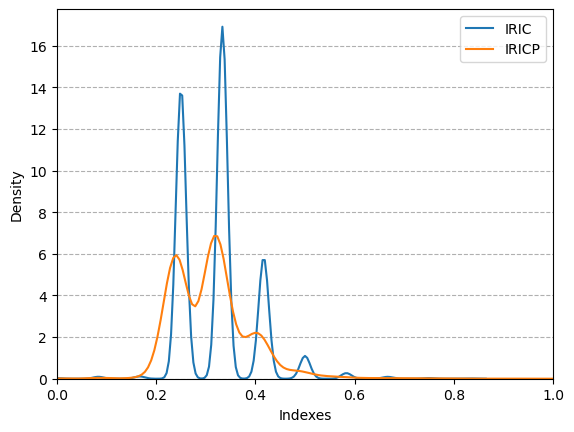

In [68]:
sns.kdeplot(data=secop2_CE_api, x='iric')
sns.kdeplot(data=secop2_CE_api, x='iricp', bw_adjust=2)
plt.xlabel('Indexes')
plt.legend(['IRIC', 'IRICP'])
plt.grid(axis='y', linestyle='--')
plt.xlim([0, 1])
plt.show()

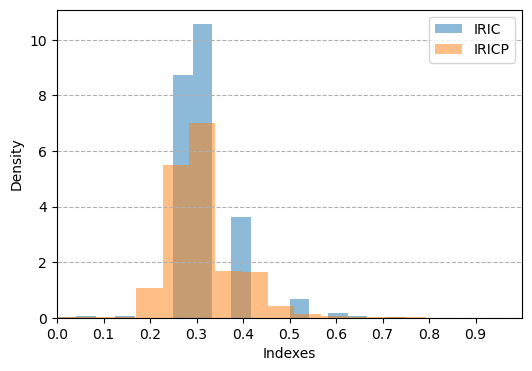

In [69]:
plt.figure(figsize=(6, 4))
plt.hist(secop2_CE_api['iric'], bins=20, alpha=0.5, density=True, label='IRIC')
plt.hist(secop2_CE_api['iricp'], bins=20, alpha=0.5, density=True, label='IRICP')
plt.xlabel('Indexes')
plt.ylabel('Density')
plt.xlim([0, 1])
plt.xticks(np.arange(0, 1, step=0.1))
plt.grid(axis='y', linestyle='--')
plt.legend()
#plt.savefig('created_data/figures/hist_iric_iricp.svg')

In [70]:
print('Highest IRIC')
secop2_CE_api.sort_values('iric', ascending=False).head(1)

Highest IRIC


,id_contrato,tipo_de_contrato,sector,valor_del_contrato,fecha_de_firma,codigo_de_categoria_principal,justificacion_modalidad_de,proceso_de_compra,documento_proveedor,modalidad_de_contratacion,tipodocproveedor,nombre_entidad,proveedores_unicos_con,proveedores_invitados,Dias Inicio-Firma Contrato,Dias Fin-Inicio Contrato,Dias Inicio-Firma Ejecucion,Dias Fin-Inicio Ejecucion,Dias Proveedor Inscrito,Dias Proceso Contratacion Abierto,Periodo de Decision,Mes Firma Contrato_Feb,Sector_Cultura,Sector_Salud y Proteccion Social,Justificacion Modalidad de Contratacion_Decreto 092 de 2017,Grupo categoria principal_Servicios administrativos,Segmento_categoria_principal_servicios_salud,Tipo_contrato_prestacion_de_servicios,adicion_valor_proveedor,adicion_tiempo_proveedor,proveedor_recurrente,proveedor_multiproposito,proveedor_multientidad,contratacion_directa,contratacion_regimen_especial,ausencia_proceso_contratacion,duracion_extrema_proceso,periodo_decision_extremo,proponente_unico,presencia_errores,iric,iricp
10814,CO1.PCCNTR.1487512,Otro,Salud y Protección Social,22000000000,2020-04-03,85101500,contratosconveniosinteradministrativosconvalor,CO1.BDOS.1191618,900959051,Contratación Directa (con ofertas),NIT,FONDO FINANCIERO DISTRITAL DE SALUD..,1.000,1,4,176,1,179,0,0,0,0,0,1,0,0,1,0,1.000,1.000,1.000,1.000,1.000,1,0,0,1,1,1,1,0.833,1.135


In [71]:
print('Highest IRICP')
secop2_CE_api.sort_values('iricp', ascending=False).head(1)

Highest IRICP


,id_contrato,tipo_de_contrato,sector,valor_del_contrato,fecha_de_firma,codigo_de_categoria_principal,justificacion_modalidad_de,proceso_de_compra,documento_proveedor,modalidad_de_contratacion,tipodocproveedor,nombre_entidad,proveedores_unicos_con,proveedores_invitados,Dias Inicio-Firma Contrato,Dias Fin-Inicio Contrato,Dias Inicio-Firma Ejecucion,Dias Fin-Inicio Ejecucion,Dias Proveedor Inscrito,Dias Proceso Contratacion Abierto,Periodo de Decision,Mes Firma Contrato_Feb,Sector_Cultura,Sector_Salud y Proteccion Social,Justificacion Modalidad de Contratacion_Decreto 092 de 2017,Grupo categoria principal_Servicios administrativos,Segmento_categoria_principal_servicios_salud,Tipo_contrato_prestacion_de_servicios,adicion_valor_proveedor,adicion_tiempo_proveedor,proveedor_recurrente,proveedor_multiproposito,proveedor_multientidad,contratacion_directa,contratacion_regimen_especial,ausencia_proceso_contratacion,duracion_extrema_proceso,periodo_decision_extremo,proponente_unico,presencia_errores,iric,iricp
10814,CO1.PCCNTR.1487512,Otro,Salud y Protección Social,22000000000,2020-04-03,85101500,contratosconveniosinteradministrativosconvalor,CO1.BDOS.1191618,900959051,Contratación Directa (con ofertas),NIT,FONDO FINANCIERO DISTRITAL DE SALUD..,1.000,1,4,176,1,179,0,0,0,0,0,1,0,0,1,0,1.000,1.000,1.000,1.000,1.000,1,0,0,1,1,1,1,0.833,1.135


In [72]:
# Mean IRIC by entity
entity_mean_idxs = secop2_CE_api[['nombre_entidad', 'iric', 'iricp']].groupby('nombre_entidad').mean()

In [73]:
print('Entidades con mayor IRIC promedio')
entity_mean_idxs.sort_values('iric', ascending=False).head(5)

Entidades con mayor IRIC promedio


,iric,iricp
nombre_entidad,,
TERMINAL DE TRANSPORTE S.A,0.667,0.739
IDIGER,0.403,0.396
ALCALDIA LOCAL DE PUENTE ARANDA-FONDO DE DESARROLLO LOCAL,0.389,0.368
ALCALDIA LOCAL DE KENNEDY,0.384,0.372
UNIDAD ADMINISTRATIVA ESPECIAL CUERPO OFICIAL DE BOMBEROS DE BOGOTA,0.377,0.355


In [74]:
print(entity_mean_idxs.sort_values('iric', ascending=False).head(5).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  iric &  iricp \\
nombre\_entidad                                                      &       &        \\
\midrule
TERMINAL DE TRANSPORTE S.A                                          & 0.667 &  0.739 \\
IDIGER                                                              & 0.403 &  0.396 \\
ALCALDIA LOCAL DE PUENTE ARANDA-FONDO DE DESARROLLO LOCAL           & 0.389 &  0.368 \\
ALCALDIA LOCAL DE KENNEDY                                           & 0.384 &  0.372 \\
UNIDAD ADMINISTRATIVA ESPECIAL CUERPO OFICIAL DE BOMBEROS DE BOGOTA & 0.377 &  0.355 \\
\bottomrule
\end{tabular}



In [75]:
print('Entidades con mayor IRICP promedio')
entity_mean_idxs.sort_values('iricp', ascending=False).head(5)

Entidades con mayor IRICP promedio


,iric,iricp
nombre_entidad,,
TERMINAL DE TRANSPORTE S.A,0.667,0.739
IDIGER,0.403,0.396
FONDO DE PRESTACIONES ECONOMICAS CESANTIAS Y PENSIONES,0.375,0.379
SECRETARIA DISTRITAL DE INTEGRACIÓN SOCIAL...,0.328,0.374
ALCALDIA LOCAL DE KENNEDY,0.384,0.372
